<font size=5  color=#003366> [LINMA2472] - Algorithms in Data Science <br>
Project 1: Networks </font> <br><br>
<font size=3  color=#003366>  Students: Iacopo Canetta, Giovanni Faldani, Constance Nkweya Tofeun
<br><br>

- <font size=4  color=#003366>Task 1: building the co-occurence network of characters </font> <br><br>
In this project we'll build a graph network representing the bonds between characters present in the classical novel "The Betrothed" by Alessandro Manzoni

In [1]:
# basic imports
import numpy as np
from numpy import linalg as LA
import pandas as pd # useful dataframe support
import scipy as sp
from matplotlib import pyplot as plt # plot operations
import networkx as nx # useful for network operations
import nltk # useful for sentence parsing
import re # regular expressions for text parsing and finding proper names
import networkx.algorithms.community as nx_comm
import sklearn
from sklearn.cluster import SpectralClustering
import communities.algorithms as comm
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Giovanni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# text file parsing
#txt_filename = "./data/pg35155.txt"
txt_filename = "./data/les_trois_mousquetaire.txt"

text = []
with open(txt_filename, "r", encoding='utf-8') as input_f:
    text = input_f.read()

# split text by paragraph

paragraphs = re.split("(?<!\")\n\n(?<!\")", text)#\n is the name for skipping to the next line
print("The text is composed of {} paragraphs!\n".format(len(paragraphs)))

# extract all individual sentences from a text
def sentences_in(text):
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

    sentences = sent_detector.tokenize(text.strip())
    return sentences

# extract all the dialogue within quotations in a text
def dialogue_in(text):
    normalQuotes = re.findall('"([^"]*)"', text)
    directionalQuotes = re.findall('“([^”]*)”', text)
    return normalQuotes + directionalQuotes

# extract all words beginning with a capital letter in a text
def proper_names_in(text):
    return re.findall("[A-Z][a-z]+", text)

# test with a random paragraph
n = 75

print(paragraphs[n])
dialogues = dialogue_in(paragraphs[n])
sentences = sentences_in(paragraphs[n])
names = proper_names_in(paragraphs[n])
print("\nParagraph {} is composed of {} sentences, {} dialogues and {} proper names".format(
    n, len(sentences), len(dialogues), len(names)))
print("The first sentence is: \n", sentences[0])
if(len(dialogues)!=0):
    print("The first dialogue is: \n", dialogues[0])
print("The first 'name' is: \n", names[0])

The text is composed of 8103 paragraphs!

“You are right,” cried the gentleman; “begone then, on your part, and I will depart as quickly on mine.” And bowing to the lady, he sprang into his saddle, while her coachman applied his whip vigorously to his horses. The two interlocutors thus separated, taking opposite directions, at full gallop.

Paragraph 75 is composed of 2 sentences, 2 dialogues and 3 proper names
The first sentence is: 
 “You are right,” cried the gentleman; “begone then, on your part, and I will depart as quickly on mine.” And bowing to the lady, he sprang into his saddle, while her coachman applied his whip vigorously to his horses.
The first dialogue is: 
 You are right,
The first 'name' is: 
 You


- As we can see finding the proper names of characters is no easy task, so we decided to rely on a curated external list of characters to look for matches and build our graph.

In [3]:
# let's list all the proper names in the book. This might take a while...
allNames = set(proper_names_in(text))
print(allNames)
# need to make a decision here

{'Conceal', 'Who', 'Clercs', 'Fifty', 'Kitty', 'Timeo', 'Pah', 'November', 'Nearly', 'Pope', 'Tower', 'Traitorous', 'Austrian', 'There', 'Finish', 'By', 'Perhaps', 'Musketeer', 'Trifles', 'Jesuit', 'Argumentum', 'Learn', 'Endowed', 'Guitant', 'Gold', 'Know', 'Devoted', 'Uzes', 'Come', 'Hearing', 'Neufch', 'Everybody', 'Masses', 'Pau', 'Norman', 'Frenchmen', 'Most', 'Reunited', 'Jesuits', 'Breathing', 'Pack', 'Bethulia', 'Englishmen', 'Bad', 'Making', 'Nevers', 'Liancourt', 'Wardes', 'Copies', 'Seeing', 'Preaux', 'Consider', 'Preacher', 'Surgis', 'Bayonne', 'Up', 'Milady', 'Eat', 'Baroness', 'German', 'Vaugirard', 'Erquinheim', 'Ferussac', 'Apocalypse', 'Baradas', 'Villainous', 'Gives', 'Vainglorious', 'Dompierre', 'Principal', 'Gray', 'Forges', 'Such', 'Battle', 'Samson', 'Others', 'Grace', 'Greeks', 'Ordination', 'Bible', 'Capricious', 'If', 'Chaillot', 'Touraine', 'Unfortunately', 'Vain', 'Cond', 'Romance', 'Mousqueton', 'Haste', 'Drawing', 'Unlucky', 'Butler', 'Whether', 'Enfants', 

In [4]:
#open character list
#txt_filename = "./data/CharacterList.txt"
txt_filename = "./data/name_list.txt"

characterList = []
with open(txt_filename, "r") as input_f:
    characterList = input_f.read()

#parsing characterlist and counting them
mainCharacters = re.split("\n", characterList)
totalCharacters = len(mainCharacters)
print(mainCharacters)

# making dictionary of associations {graph node : character}
nodeCharacter = dict()
for i in range(len(mainCharacters)):
    nodeCharacter[i] = mainCharacters[i]
    
print("\n Node associations: ", nodeCharacter)

['Athos', 'Milady', 'Porthos', 'Cardinal', 'Aramis', 'Bonacieux', 'Treville', 'Felton', 'Planchet', 'Kitty', 'Grimaud', 'Bazin', 'Coquenard', 'Gascon', 'Louis', 'Wardes', 'Anne', 'Rochefort', 'Richelieu', 'Laporte', 'Dessessart', 'Rochellais', 'Patrick', 'Tremouille', 'Bethune', 'Meung', 'Bernajoux', 'Cahusac', 'Artagnan', 'Mousqueton', 'Constance', 'Bassompierre', 'Bicarat', 'Lubin', 'Busigny', 'Henry']

 Node associations:  {0: 'Athos', 1: 'Milady', 2: 'Porthos', 3: 'Cardinal', 4: 'Aramis', 5: 'Bonacieux', 6: 'Treville', 7: 'Felton', 8: 'Planchet', 9: 'Kitty', 10: 'Grimaud', 11: 'Bazin', 12: 'Coquenard', 13: 'Gascon', 14: 'Louis', 15: 'Wardes', 16: 'Anne', 17: 'Rochefort', 18: 'Richelieu', 19: 'Laporte', 20: 'Dessessart', 21: 'Rochellais', 22: 'Patrick', 23: 'Tremouille', 24: 'Bethune', 25: 'Meung', 26: 'Bernajoux', 27: 'Cahusac', 28: 'Artagnan', 29: 'Mousqueton', 30: 'Constance', 31: 'Bassompierre', 32: 'Bicarat', 33: 'Lubin', 34: 'Busigny', 35: 'Henry'}


In [5]:
#cleans a list of characters !!!TODO eliminate duplicates
def clean_names(characterList, mainCharacters):
    for character in list(characterList):
        if character not in mainCharacters:
            characterList.remove(character)
            
    
#iterate over cleant list and updates matrix (lamest optimization ever)
def update_matrix(characterList, mainCharacters, matrix):
    if len(characterList) < 2:
        return
    
    for i in range(len(characterList)):
        currentCharacterIndex = mainCharacters.index(characterList[i])
        for j in range(len(characterList) - i - 1):
            secondCharacterIndex = mainCharacters.index(characterList[j + i + 1])
            matrix[currentCharacterIndex][secondCharacterIndex] += 1;
            matrix[secondCharacterIndex][currentCharacterIndex] += 1;
            
            

#matrix totalCharacters * totalCharacters initialized with all 0s
adjacencyMatrix = [[0 for _ in range(totalCharacters)] for _ in range(totalCharacters)]

#iterate over paragraphs and get proper names
for i in range(len(paragraphs)):
    paragraphCharacters = proper_names_in(paragraphs[i])
    paragraphCharacters = list( dict.fromkeys(paragraphCharacters))
    clean_names(paragraphCharacters, mainCharacters)
    update_matrix(paragraphCharacters, mainCharacters, adjacencyMatrix)
    
print(adjacencyMatrix)


[[0, 33, 117, 6, 137, 21, 39, 0, 30, 4, 50, 11, 0, 11, 3, 2, 1, 2, 2, 0, 2, 6, 0, 4, 3, 0, 3, 12, 252, 6, 3, 0, 3, 0, 5, 1], [33, 0, 6, 0, 5, 17, 5, 75, 5, 32, 0, 3, 0, 11, 0, 21, 1, 7, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 110, 0, 1, 0, 0, 0, 0, 0], [117, 6, 0, 1, 149, 5, 14, 0, 11, 1, 10, 8, 30, 5, 1, 2, 0, 3, 1, 0, 1, 1, 0, 2, 1, 1, 3, 3, 113, 26, 0, 0, 4, 0, 1, 1], [6, 0, 1, 0, 0, 3, 7, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 8, 0, 1, 0, 0, 0, 0, 0, 1, 0, 10, 0, 0, 0, 0, 0, 0, 1], [137, 5, 149, 0, 0, 12, 20, 0, 13, 1, 7, 28, 1, 6, 1, 2, 1, 2, 1, 0, 2, 0, 0, 3, 3, 0, 3, 5, 144, 7, 1, 0, 4, 0, 1, 0], [21, 17, 5, 3, 12, 0, 9, 0, 8, 2, 0, 0, 0, 1, 0, 2, 1, 9, 2, 4, 1, 0, 0, 1, 4, 1, 0, 0, 88, 0, 3, 0, 0, 0, 0, 0], [39, 5, 14, 7, 20, 9, 0, 0, 3, 1, 0, 0, 0, 9, 6, 1, 0, 0, 0, 0, 14, 0, 0, 11, 1, 3, 3, 2, 87, 0, 0, 1, 1, 0, 0, 3], [0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0], [30, 5, 11, 1, 13, 8, 3, 0, 0, 0, 19, 14, 0, 0, 2, 2, 0, 2, 0, 0

- Making the graph

Graph with 36 nodes and 212 edges


C:\Users\Giovanni\AppData\Local\Temp\ipykernel_4632\2531750575.py:20: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


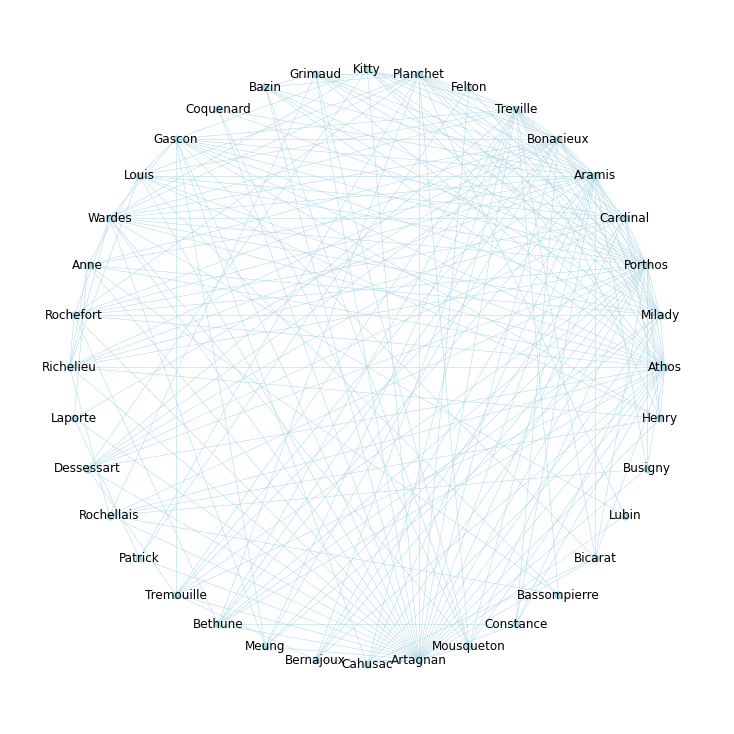

In [6]:
G = nx.Graph()

# add one node per character
for i in range(len(mainCharacters)):
    G.add_node(i, size = 1)
    
    
# add node labels
nx.set_node_attributes(G, nodeCharacter, name='Names')

# add the edges from the adjacency matrix (avoid duplicates)

for i in range(len(adjacencyMatrix)-1):
    for j in range(i+1, len(adjacencyMatrix[0])):
        if adjacencyMatrix[i][j] != 0 :
            G.add_edge(i,j, weight = adjacencyMatrix[i][j])
    
    
    
print(nx.info(G))
#print(G.nodes[0][""])

def print_graph(G):
    g_draw = G

    fig = plt.figure(figsize=(10,10))
    pos = nx.circular_layout(g_draw)
    nx.draw(g_draw, pos, node_color='lightblue', edge_color='lightblue', node_size=50, labels = nx.get_node_attributes(G, 'Names'), with_labels = True, width=0.5)
    plt.show()
    
print_graph(G)

<font size=4> Preliminary observations about the graph: </font>

- Graph shape





- Degree assortativity: disassortative network

In [7]:
def  find_assortativity(graph):
    return nx.degree_assortativity_coefficient(graph)

assortativity = find_assortativity(G)
print(assortativity)

-0.3468460591796397


- Community detection with Louvain algorithm and Spectral clustering

Louvain algo detected:  [{32, 2, 4, 27, 11, 12, 29}, {1, 17, 7, 25, 13, 9, 15}, {34, 3, 35, 14, 16, 18, 19, 21, 22, 31}, {0, 33, 5, 6, 8, 10, 20, 23, 24, 26, 28, 30}]
Laplacian eigenvalues :  [ 3.50040012e+01  2.90906692e+01  2.89726701e+01  2.70951547e+01
  2.22085563e+01  2.11023038e+01 -4.54607873e-15  1.88565417e+01
  1.79304927e+01  1.70824261e+01  1.65827671e+01  1.48738960e+01
  2.19612844e+00  1.32224361e+01  2.87415836e+00  3.34857581e+00
  3.53034989e+00  3.90962313e+00  1.22377692e+01  4.68753256e+00
  5.07883150e+00  5.54766973e+00  5.92863716e+00  6.29219812e+00
  6.53981383e+00  7.08112713e+00  7.60994117e+00  1.09294890e+01
  8.21339120e+00  1.04663474e+01  1.01306037e+01  9.04244393e+00
  9.24480348e+00  9.49578907e+00  9.59286116e+00  8.00000000e+00]
SKL Spectral Clustering algo detected communities with labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Plot of louvain communities:


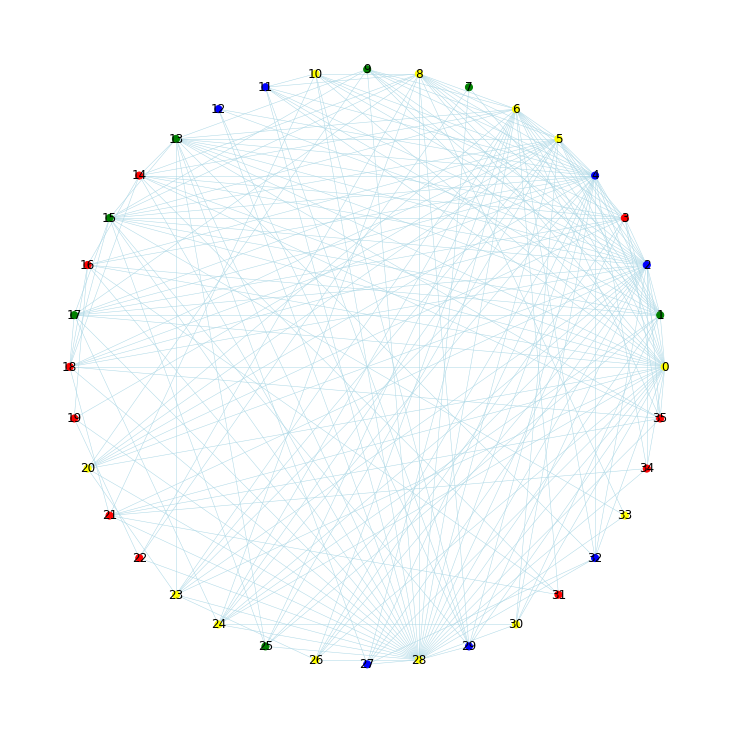

Plot of spectral communities:


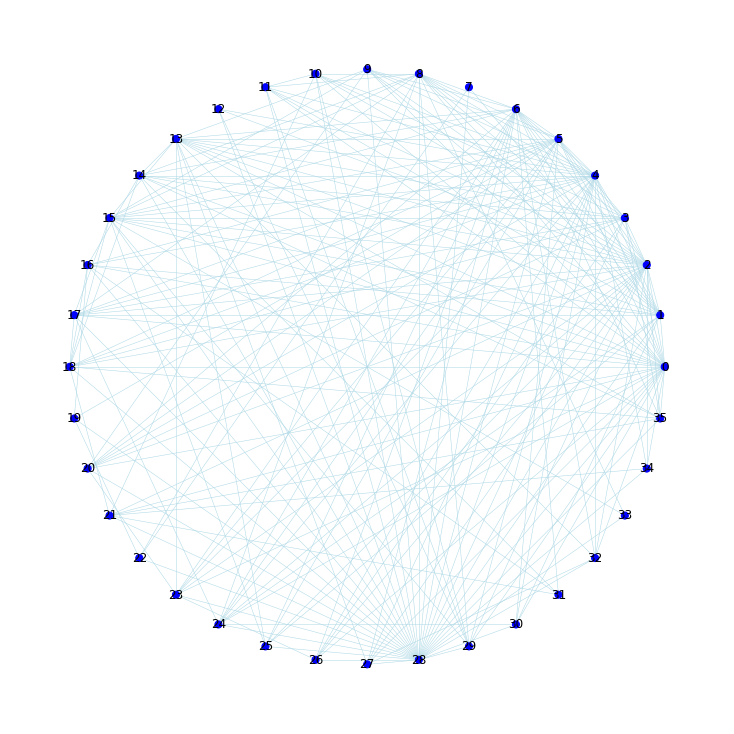

In [8]:
#Louvain algorithm

communities1 = nx_comm.louvain_communities(G)
print("Louvain algo detected: ", communities1)

# Spectral clustering

#prepare the adjacency matrix
npMat = np.array([np.array(row) for row in adjacencyMatrix])
"""
for i in range(npMat.shape[0]):
    for j in range(npMat.shape[1]):
        if npMat[i][j] != 0:
            npMat[i][j] = 1
"""
# Compute Laplacian matrix and set k to the number of eigenvalues "close" to zero -> optmal k
Laplacian = npMat.copy()

# edges are only counted with weight 1 for the Laplacian

for i in range(Laplacian.shape[0]):
    for j in range(Laplacian.shape[1]):
        if Laplacian[i][j] != 0:
            Laplacian[i][j] = -1

for i in range(len(Laplacian)):
    Laplacian[i][i] = nx.degree(G, i)

# there should be at least one ZERO eigenvalue, then k-1 eignevalues CLOSE to zero
w,v = LA.eig(Laplacian)
print("Laplacian eigenvalues : ", w)

#for the three musketeers, it looks like there is 1 eigenvalue close or equal to zero
k=1

clustering = sklearn.cluster.SpectralClustering(n_clusters=k, assign_labels='discretize', random_state=0, affinity='precomputed_nearest_neighbors').fit(npMat)
communities2 = clustering.labels_
print("SKL Spectral Clustering algo detected communities with labels: ", communities2)

# plot the communities
def plot_louvain_comm(G, community_):
    color_map = []
    # color up to 10 communities
    color_list = ['blue', 'green', 'red', 'yellow', 'purple', 'orange', 'cyan', 'brown', 'black', 'white']
    for node in G:
        for i in range(len(community_)):
            if node in community_[i]:
                color_map.append(color_list[i])
    
    g_draw = G          
    fig = plt.figure(figsize=(10,10))
    pos = nx.circular_layout(g_draw)
    nx.draw(g_draw, pos, node_color=color_map, edge_color='lightblue', node_size=50, with_labels=True, width=0.5)
    plt.show()
    
def plot_spectral_comm(G, community_):
    color_map = []
    # color up to 10 communities
    color_list = ['blue', 'green', 'red', 'yellow', 'purple', 'orange', 'cyan', 'brown', 'black', 'white']
    for i in range(len(G.nodes)):
        color_map.append(color_list[community_[i]])
    
    g_draw = G          
    fig = plt.figure(figsize=(10,10))
    pos = nx.circular_layout(g_draw)
    nx.draw(g_draw, pos, node_color=color_map, edge_color='lightblue', node_size=50, with_labels=True, width=0.5)
    plt.show()
    
print("Plot of louvain communities:")
plot_louvain_comm(G, communities1)

print("Plot of spectral communities:")
plot_spectral_comm(G, communities2)


- Comparison of the two methods



<font size=4> Influence maximization problem </font>

IC model from: https://github.com/AdnanRasad/Influence-Maximization-Analysis/blob/master/Kempe-Independent-Cascades-Model/IC-Graph:Networkx-Python

tuple to list: https://stackoverflow.com/questions/12142133/how-to-get-first-element-in-a-list-of-tuples

In [9]:
# k = int(G.number_of_nodes() * 0.05)

k = 3

print(k)

# simulates Num_of_Simulations loops of Independent Cascade
def IC(Networkx_Graph,Seed_Set,Probability,Num_of_Simulations):
    spread = []
    Y = []
    
    for i in range(Num_of_Simulations):
        Y.append([])
        Y[i].append(len(Seed_Set) / len(G.nodes))
        new_active, Ans = Seed_Set[:], Seed_Set[:]
        while new_active:
            #Getting neighbour nodes of newly activate node
            targets = Neighbour_finder(Networkx_Graph,Probability,new_active)
    
            #Calculating if any nodes of those neighbours can be activated, if yes add them to new_ones.
            np.random.seed(i)
            success = np.random.uniform(0,1,len(targets)) < Probability
            new_ones = list(np.extract(success, sorted(targets)))
            
            #Checking which ones in new_ones are not in our Ans...only adding them to our Ans so that no duplicate in Ans.
            new_active = list(set(new_ones) - set(Ans))
            Ans += new_active
            infOverTot = len(Ans) / len(G.nodes)
            Y[i].append(infOverTot)
        
        spread.append(len(Ans))
    
    maxRowLenght = Max_Row_Len(Y)
    Even_Rows(Y, maxRowLenght)
    return(np.mean(spread), Y)
      

#finds all the neighbors available for a set of nodes
def Neighbour_finder(g,p,new_active):
    
    targets = []
    for node in new_active:
        targets += g.neighbors(node)

    return(targets)


#returns the max len among the rows
def Max_Row_Len(listOfLists):
    lenghts = []
    
    for i in range(len(listOfLists)):
        lenghts.append(len(listOfLists[i]))
        
    return max(lenghts)


#Even the rows out appending the last element to get them maxLenght long
def Even_Rows(listOfLists, maxLenght):    
    for i in range(len(listOfLists)):
        elementsToAdd = maxLenght - len(listOfLists[i])
        currentLen = len(listOfLists[i])
        lastIndex = max(currentLen - 1, 0)
        lastElement = listOfLists[i][lastIndex]
        
        for j in range(elementsToAdd):
            listOfLists[i].append(lastElement)
        

#TODO find an adequate influence function for a set of nodes A
#Run IC a 'large' number of times to find realizations X_i (By 'large' I mean like 10 let's not make this take forever)
#Compute probability for each realization X_i, still unclear on how to do that because the notes are vague af

def Greedy_Influence_Maximization(G, k, Probability, Num_of_Simulations):
    A0 = []
    V = G.nodes
    while(len(A0) < k):
        availableNodes = V - A0
        max = 0
        for node in availableNodes:
            value = IC(G, A0 + [node], Probability, Num_of_Simulations)[0]
            if (value > max):
                max = value
                v = node
        A0 = A0 + [v]
    return A0

maxInfluenceSet = Greedy_Influence_Maximization(G, k, Probability=0.5, Num_of_Simulations=4)

print(maxInfluenceSet)

#Compare runs if IC starting from MI set to other runs starting from k max degree nodes

MI_spread = IC(G, maxInfluenceSet, Probability=0.5, Num_of_Simulations=5044)

#Extract the set of 3 nodes of maximum degree
maxDegSet = sorted(G.degree, key=lambda tup: tup[1], reverse=True)[:len(maxInfluenceSet)]
maxDegSet = [i[0] for i in maxDegSet]

MaxDegSpread = IC(G, maxDegSet, Probability=0.5, Num_of_Simulations=4)

#print(MaxDegSpread)
#print(MI_spread)


3
[26, 4, 27]


In [10]:
print(MaxDegSpread[1])

[[0.08333333333333333, 0.8611111111111112, 0.9722222222222222, 0.9722222222222222], [0.08333333333333333, 0.7222222222222222, 0.9444444444444444, 0.9444444444444444], [0.08333333333333333, 0.8611111111111112, 0.9722222222222222, 0.9722222222222222], [0.08333333333333333, 0.8055555555555556, 1.0, 1.0]]


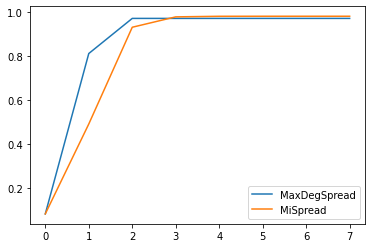

In [11]:
import matplotlib.pyplot as plt


#makes the all the rows at the same lenght (evens out epochs for all the tests)
maxRowLenght = max(len(MaxDegSpread[1][0]), len(MI_spread[1][0]))
Even_Rows(MaxDegSpread[1], maxRowLenght)
Even_Rows(MI_spread[1], maxRowLenght)

#converts Y to numpy array
yMiSpread = np.array(MI_spread[1])
yMaxDegSpread = np.array(MaxDegSpread[1])

yMiSpread = np.mean(yMiSpread, axis=0)
yMaxDegSpread = np.mean(yMaxDegSpread, axis=0)


#plot graph

x = range(0, maxRowLenght)

plt.plot(x, yMaxDegSpread, label = "MaxDegSpread")
plt.plot(x, yMiSpread, label = "MiSpread")
plt.legend()
plt.show()





- Barabasi-Albert comparison

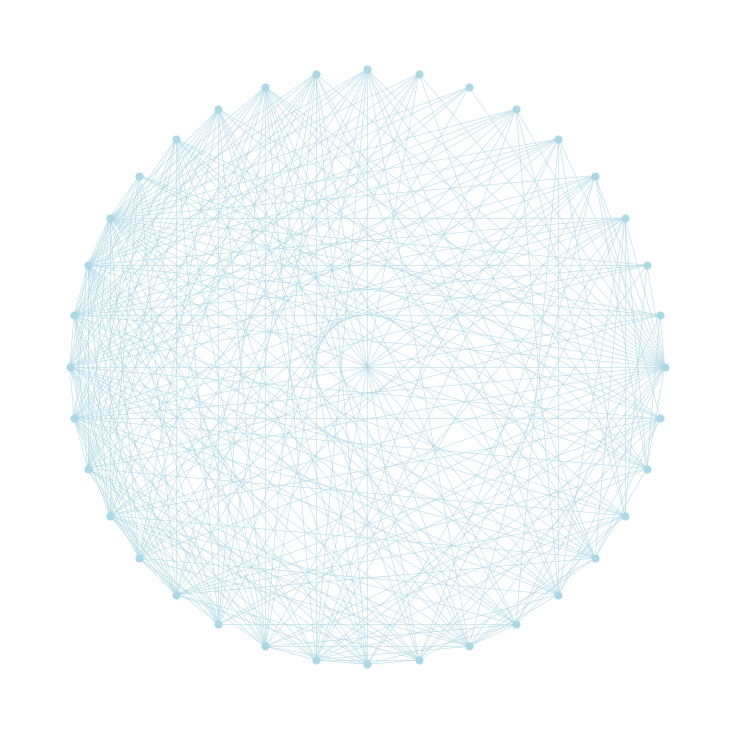

In [12]:
#Generate graph with same number of nodes and average degree

H = nx.barabasi_albert_graph(len(G.nodes), int(np.mean(G.degree)))

print_graph(H)

Compute the Greedy Influence Maximization algorithm on the new network

In [13]:
BarbMaxInfluenceSet = Greedy_Influence_Maximization(H, k, Probability=0.5, Num_of_Simulations=4)
print(BarbMaxInfluenceSet)

[1, 0, 2]
